# Hamming Distance vs Energy Barrier Analysis

This notebook investigates how the **energy barrier** (max distance from natural) varies with **Hamming distance** between sequence pairs.

## Hypothesis:
Sequences that are more different from each other (higher Hamming distance) may require passing through higher energy intermediate states during evolution.

## Approach:
1. Generate a pool of functional overlapping sequences at fixed overlap
2. Calculate all pairwise Hamming distances
3. Bin pairs by Hamming distance and sample from each bin
4. Run GA to find optimal evolutionary paths for each pair
5. Analyze relationship: Hamming distance vs max energy barrier

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange
from tqdm.auto import tqdm
import pandas as pd
from collections import defaultdict
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import from local module
import overlappingGenes as og

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\orson\Documents\GitHub\OverlappingGenes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

In [2]:
# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

# Protein families
PROTEIN_1 = 'PF00004'
PROTEIN_2 = 'PF00041'

# Fixed overlap for this experiment
OVERLAP = 12

# Sequence generation
N_SEQUENCES = 30  # Number of functional sequences to generate (more = better coverage)
MC_ITERATIONS = 250_000  # MC iterations per sequence

# Hamming distance binning
N_BINS = 10  # Number of Hamming distance bins
PAIRS_PER_BIN = 3  # Number of pairs to sample from each bin

# GA parameters
GA_POPULATION = 75
GA_GENERATIONS = 150

print(f"Experiment Configuration:")
print(f"  Proteins: {PROTEIN_1} + {PROTEIN_2}")
print(f"  Overlap: {OVERLAP} nucleotides")
print(f"  Sequences to generate: {N_SEQUENCES}")
print(f"  Hamming distance bins: {N_BINS}")
print(f"  Pairs per bin: {PAIRS_PER_BIN}")
print(f"  Max pairs to analyze: {N_BINS * PAIRS_PER_BIN}")

Experiment Configuration:
  Proteins: PF00004 + PF00041
  Overlap: 12 nucleotides
  Sequences to generate: 30
  Hamming distance bins: 10
  Pairs per bin: 3
  Max pairs to analyze: 30


## 3. Load DCA Parameters

In [3]:
# Load DCA parameters for both proteins
print(f"Loading DCA parameters for {PROTEIN_1}...")
Jvec_1, hvec_1 = og.extract_params(f'{PROTEIN_1}/{PROTEIN_1}_params.dat')
nat_energies_1 = og.load_natural_energies(f'{PROTEIN_1}/{PROTEIN_1}_naturalenergies.txt')
mean_e1, std_e1 = np.mean(nat_energies_1), np.std(nat_energies_1)
print(f"  Length: {len(hvec_1)//21} AA, Mean energy: {mean_e1:.2f} ± {std_e1:.2f}")

print(f"\nLoading DCA parameters for {PROTEIN_2}...")
Jvec_2, hvec_2 = og.extract_params(f'{PROTEIN_2}/{PROTEIN_2}_params.dat')
nat_energies_2 = og.load_natural_energies(f'{PROTEIN_2}/{PROTEIN_2}_naturalenergies.txt')
mean_e2, std_e2 = np.mean(nat_energies_2), np.std(nat_energies_2)
print(f"  Length: {len(hvec_2)//21} AA, Mean energy: {mean_e2:.2f} ± {std_e2:.2f}")

# Store DCA params as tuples for numba
DCA_params_1 = (Jvec_1, hvec_1)
DCA_params_2 = (Jvec_2, hvec_2)

# Protein lengths (in AA, without stop codon)
prot1_len = len(hvec_1) // 21
prot2_len = len(hvec_2) // 21
len_aa_1 = prot1_len + 1  # +1 for stop codon
len_aa_2 = prot2_len + 1

print(f"\nProtein 1 length: {prot1_len} AA")
print(f"Protein 2 length: {prot2_len} AA")
print(f"Overlap: {OVERLAP} nucleotides")

Loading DCA parameters for PF00004...
  Length: 110 AA, Mean energy: 145.88 ± 38.25

Loading DCA parameters for PF00041...
  Length: 74 AA, Mean energy: 120.66 ± 17.64

Protein 1 length: 110 AA
Protein 2 length: 74 AA
Overlap: 12 nucleotides


## 4. Generate Functional Sequences

In [4]:
def generate_functional_sequence(DCA_params_1, DCA_params_2, prot1_len, prot2_len, overlap, 
                                   mean_e1, mean_e2, n_iterations=1000000, T1=1.0, T2=1.0):
    """Generate a single functional overlapping sequence using MC relaxation."""
    initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, overlap, quiet=True)
    
    result = og.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, initial_seq,
        T1=T1, T2=T2,
        numberofiterations=n_iterations,
        quiet=True,
        whentosave=10.0,
        nat_mean1=mean_e1,
        nat_mean2=mean_e2
    )
    
    best_seq = result[6]  # Actual sequence corresponding to best energies
    best_energies = result[5]  # [E1, E2] closest to natural
    
    return best_seq, best_energies

# JIT warm-up
print("Warming up JIT compilation...")
_ = generate_functional_sequence(DCA_params_1, DCA_params_2, prot1_len, prot2_len, OVERLAP,
                                  mean_e1, mean_e2, n_iterations=1000)
print("Done!")

Warming up JIT compilation...
Done!


In [5]:
# Generate sequence pool
sequences = []
energies = []

print(f"Generating {N_SEQUENCES} functional sequences...")
for i in tqdm(range(N_SEQUENCES)):
    seq, best_e = generate_functional_sequence(
        DCA_params_1, DCA_params_2, prot1_len, prot2_len, OVERLAP,
        mean_e1, mean_e2, n_iterations=MC_ITERATIONS,
        T1=0.818, T2=0.955
    )
    sequences.append(seq)
    energies.append(best_e)

energies = np.array(energies)
print(f"\nGenerated {len(sequences)} sequences")
print(f"Energy range (E1): {energies[:, 0].min():.2f} to {energies[:, 0].max():.2f}")
print(f"Energy range (E2): {energies[:, 1].min():.2f} to {energies[:, 1].max():.2f}")

Generating 30 functional sequences...


100%|██████████| 30/30 [00:15<00:00,  1.98it/s]


Generated 30 sequences
Energy range (E1): 145.44 to 146.12
Energy range (E2): 120.36 to 120.91


## 5. Calculate Pairwise Hamming Distances

In [6]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two nucleotide sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Calculate all pairwise Hamming distances
n = len(sequences)
distances = np.zeros((n, n))

print("Calculating pairwise Hamming distances...")
for i in tqdm(range(n)):
    for j in range(i+1, n):
        d = hamming_distance(sequences[i], sequences[j])
        distances[i, j] = d
        distances[j, i] = d

# Get all unique pairs with their distances
all_pairs = []
for i in range(n):
    for j in range(i+1, n):
        all_pairs.append((i, j, distances[i, j]))

print(f"\nTotal pairs: {len(all_pairs)}")
hamming_values = [p[2] for p in all_pairs]
print(f"Hamming distance range: {min(hamming_values):.0f} - {max(hamming_values):.0f}")
print(f"Mean Hamming distance: {np.mean(hamming_values):.1f} ± {np.std(hamming_values):.1f}")

Calculating pairwise Hamming distances...


100%|██████████| 30/30 [00:00<00:00, 2206.60it/s]


Total pairs: 435
Hamming distance range: 259 - 331
Mean Hamming distance: 289.5 ± 13.0


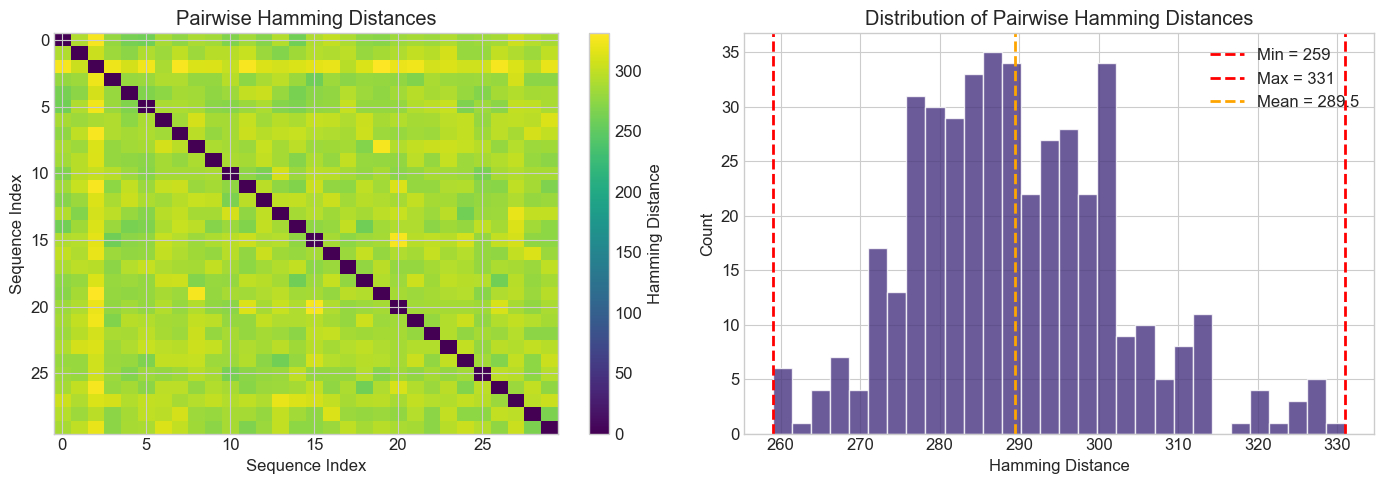

In [7]:
# Visualize Hamming distance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax1 = axes[0]
im = ax1.imshow(distances, cmap='viridis', aspect='auto')
plt.colorbar(im, ax=ax1, label='Hamming Distance')
ax1.set_xlabel('Sequence Index')
ax1.set_ylabel('Sequence Index')
ax1.set_title('Pairwise Hamming Distances')

# Histogram with bins marked
ax2 = axes[1]
upper_tri = distances[np.triu_indices(n, k=1)]
ax2.hist(upper_tri, bins=30, edgecolor='white', alpha=0.8)
ax2.axvline(np.min(upper_tri), color='red', linestyle='--', linewidth=2, label=f'Min = {int(np.min(upper_tri))}')
ax2.axvline(np.max(upper_tri), color='red', linestyle='--', linewidth=2, label=f'Max = {int(np.max(upper_tri))}')
ax2.axvline(np.mean(upper_tri), color='orange', linestyle='--', linewidth=2, label=f'Mean = {np.mean(upper_tri):.1f}')
ax2.set_xlabel('Hamming Distance')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Pairwise Hamming Distances')
ax2.legend()

plt.tight_layout()
plt.savefig('hamming_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Bin Pairs by Hamming Distance

In [8]:
# Create bins across the Hamming distance range
min_ham = min(hamming_values)
max_ham = max(hamming_values)
bin_edges = np.linspace(min_ham, max_ham, N_BINS + 1)

print(f"Hamming distance bins:")
for i in range(N_BINS):
    print(f"  Bin {i+1}: [{bin_edges[i]:.0f}, {bin_edges[i+1]:.0f})")

# Assign pairs to bins
binned_pairs = defaultdict(list)
for i, j, ham in all_pairs:
    bin_idx = np.digitize(ham, bin_edges) - 1
    bin_idx = min(bin_idx, N_BINS - 1)  # Handle edge case
    binned_pairs[bin_idx].append((i, j, ham))

print(f"\nPairs per bin:")
for bin_idx in range(N_BINS):
    print(f"  Bin {bin_idx+1}: {len(binned_pairs[bin_idx])} pairs")

Hamming distance bins:
  Bin 1: [259, 266)
  Bin 2: [266, 273)
  Bin 3: [273, 281)
  Bin 4: [281, 288)
  Bin 5: [288, 295)
  Bin 6: [295, 302)
  Bin 7: [302, 309)
  Bin 8: [309, 317)
  Bin 9: [317, 324)
  Bin 10: [324, 331)

Pairs per bin:
  Bin 1: 11 pairs
  Bin 2: 28 pairs
  Bin 3: 74 pairs
  Bin 4: 97 pairs
  Bin 5: 83 pairs
  Bin 6: 84 pairs
  Bin 7: 24 pairs
  Bin 8: 19 pairs
  Bin 9: 6 pairs
  Bin 10: 9 pairs


In [9]:
# Sample pairs from each bin
selected_pairs = []

print(f"Selecting {PAIRS_PER_BIN} pairs from each bin...")
for bin_idx in range(N_BINS):
    pairs_in_bin = binned_pairs[bin_idx]
    if len(pairs_in_bin) == 0:
        print(f"  Bin {bin_idx+1}: No pairs available, skipping")
        continue
    
    # Sample up to PAIRS_PER_BIN pairs
    n_to_sample = min(PAIRS_PER_BIN, len(pairs_in_bin))
    sampled_indices = np.random.choice(len(pairs_in_bin), n_to_sample, replace=False)
    
    for idx in sampled_indices:
        i, j, ham = pairs_in_bin[idx]
        selected_pairs.append({
            'seq_idx_1': i,
            'seq_idx_2': j,
            'hamming_distance': ham,
            'bin_idx': bin_idx
        })
    
    print(f"  Bin {bin_idx+1} [{bin_edges[bin_idx]:.0f}-{bin_edges[bin_idx+1]:.0f}]: Selected {n_to_sample} pairs")

# Sort by Hamming distance for orderly processing
selected_pairs.sort(key=lambda x: x['hamming_distance'])

print(f"\nTotal pairs selected: {len(selected_pairs)}")
print(f"Hamming distance range of selected pairs: {selected_pairs[0]['hamming_distance']:.0f} - {selected_pairs[-1]['hamming_distance']:.0f}")

Selecting 3 pairs from each bin...
  Bin 1 [259-266]: Selected 3 pairs
  Bin 2 [266-273]: Selected 3 pairs
  Bin 3 [273-281]: Selected 3 pairs
  Bin 4 [281-288]: Selected 3 pairs
  Bin 5 [288-295]: Selected 3 pairs
  Bin 6 [295-302]: Selected 3 pairs
  Bin 7 [302-309]: Selected 3 pairs
  Bin 8 [309-317]: Selected 3 pairs
  Bin 9 [317-324]: Selected 3 pairs
  Bin 10 [324-331]: Selected 3 pairs

Total pairs selected: 30
Hamming distance range of selected pairs: 259 - 331


## 7. Energy Functions and GA

In [ ]:
# =============================================================================
# NUMBA-OPTIMIZED ENERGY AND FITNESS FUNCTIONS
# =============================================================================

# Nucleotide encoding: A=0, C=1, G=2, T=3
NT_TO_INT = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
INT_TO_NT = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

def seq_to_array(seq_str):
    """Convert string sequence to numpy uint8 array."""
    return np.array([NT_TO_INT[c] for c in seq_str], dtype=np.uint8)

def array_to_seq(seq_arr):
    """Convert numpy uint8 array back to string."""
    return ''.join(INT_TO_NT[i] for i in seq_arr)

def get_mutations_arrays(seq1, seq2):
    """Get mutations as numpy arrays for numba compatibility."""
    positions = []
    old_nts = []
    new_nts = []
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            positions.append(i)
            old_nts.append(NT_TO_INT[seq1[i]])
            new_nts.append(NT_TO_INT[seq2[i]])
    return (np.array(positions, dtype=np.int32),
            np.array(old_nts, dtype=np.uint8),
            np.array(new_nts, dtype=np.uint8))


@njit
def calculate_energies_from_array(seq_arr, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2):
    """Calculate E1 and E2 from a uint8 array sequence."""
    Jvec1, hvec1 = DCA_params_1
    Jvec2, hvec2 = DCA_params_2
    
    len_seq_1_n = len_aa_1 * 3
    len_seq_2_n = len_aa_2 * 3
    
    aa_seq_1 = np.empty(len_aa_1, dtype=np.int32)
    aa_seq_2 = np.empty(len_aa_2, dtype=np.int32)
    rc_buffer = np.empty(len_seq_2_n, dtype=np.uint8)
    
    og.split_sequence_and_to_numeric_out(seq_arr, len_seq_1_n, len_seq_2_n, aa_seq_1, aa_seq_2, rc_buffer)
    
    for i in range(len_aa_1 - 1):
        if aa_seq_1[i] == 21:
            return np.inf, np.inf
    for i in range(len_aa_2 - 1):
        if aa_seq_2[i] == 21:
            return np.inf, np.inf
    
    E1 = og.calculate_Energy(aa_seq_1[:-1], Jvec1, hvec1)
    E2 = og.calculate_Energy(aa_seq_2[:-1], Jvec2, hvec2)
    
    return E1, E2


@njit
def evaluate_path_fitness_numba(path_order, seq_arr, mut_positions, mut_new_nts,
                                 DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
                                 nat_mean_1, nat_mean_2):
    """Numba-optimized fitness evaluation."""
    current_seq = seq_arr.copy()
    
    E1, E2 = calculate_energies_from_array(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
    max_distance = abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2)
    
    for i in range(len(path_order)):
        idx = path_order[i]
        pos = mut_positions[idx]
        new_nt = mut_new_nts[idx]
        current_seq[pos] = new_nt
        
        E1, E2 = calculate_energies_from_array(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
        distance = abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2)
        
        if distance > max_distance:
            max_distance = distance
    
    return max_distance


@njit(parallel=True)
def evaluate_population_parallel(population, seq_arr, mut_positions, mut_new_nts,
                                  DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
                                  nat_mean_1, nat_mean_2):
    """Parallel evaluation of entire population using numba prange."""
    pop_size = population.shape[0]
    fitnesses = np.empty(pop_size, dtype=np.float64)
    
    for i in prange(pop_size):
        fitnesses[i] = evaluate_path_fitness_numba(
            population[i], seq_arr, mut_positions, mut_new_nts,
            DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
            nat_mean_1, nat_mean_2
        )
    
    return fitnesses


# Legacy string-based function for final path extraction
@njit
def calculate_energies_separate(seq_str, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2):
    """Calculate E1 and E2 separately (string version for compatibility)."""
    Jvec1, hvec1 = DCA_params_1
    Jvec2, hvec2 = DCA_params_2
    
    seq = og.seq_str_to_int_array(seq_str)
    len_seq_1_n = len_aa_1 * 3
    len_seq_2_n = len_aa_2 * 3
    
    aa_seq_1 = np.empty(len_aa_1, dtype=np.int32)
    aa_seq_2 = np.empty(len_aa_2, dtype=np.int32)
    rc_buffer = np.empty(len_seq_2_n, dtype=np.uint8)
    
    og.split_sequence_and_to_numeric_out(seq, len_seq_1_n, len_seq_2_n, aa_seq_1, aa_seq_2, rc_buffer)
    
    for i in range(len_aa_1 - 1):
        if aa_seq_1[i] == 21:
            return np.inf, np.inf
    for i in range(len_aa_2 - 1):
        if aa_seq_2[i] == 21:
            return np.inf, np.inf
    
    E1 = og.calculate_Energy(aa_seq_1[:-1], Jvec1, hvec1)
    E2 = og.calculate_Energy(aa_seq_2[:-1], Jvec2, hvec2)
    
    return E1, E2


# JIT compile all functions
print("JIT compiling energy functions...")

# Warmup string version
_ = calculate_energies_separate(sequences[0], DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)

# Warmup array version
test_arr = seq_to_array(sequences[0])
_ = calculate_energies_from_array(test_arr, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)

# Warmup fitness evaluation
test_positions, test_old, test_new = get_mutations_arrays(sequences[0], sequences[1])
test_order = np.arange(len(test_positions), dtype=np.int32)
_ = evaluate_path_fitness_numba(test_order, test_arr, test_positions, test_new,
                                 DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
                                 mean_e1, mean_e2)

# Warmup parallel evaluation
test_pop = np.random.permutation(len(test_positions)).reshape(1, -1).astype(np.int32)
test_pop = np.vstack([test_pop, test_pop])
_ = evaluate_population_parallel(test_pop, test_arr, test_positions, test_new,
                                  DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
                                  mean_e1, mean_e2)

print("Done! Numba parallel evaluation enabled.")

In [ ]:
# Helper functions for mutation path extraction (string-based for final results)

def get_mutation_path(seq1, seq2):
    """Get the list of positions where seq1 and seq2 differ."""
    diffs = []
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            diffs.append((i, seq1[i], seq2[i]))
    return diffs

def get_full_path_energies(path_order, seq_start, mutations, DCA_params_1, DCA_params_2, 
                           len_aa_1, len_aa_2, nat_mean_1, nat_mean_2):
    """Get energies and distances at each step along the mutation path."""
    current_seq = seq_start
    E1, E2 = calculate_energies_separate(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
    
    path_e1 = [E1]
    path_e2 = [E2]
    path_energies = [E1 + E2]
    path_distances = [abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2)]
    
    for idx in path_order:
        pos, old_nt, new_nt = mutations[idx]
        current_seq = list(current_seq)
        current_seq[pos] = new_nt
        current_seq = ''.join(current_seq)
        
        E1, E2 = calculate_energies_separate(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
        
        path_e1.append(E1)
        path_e2.append(E2)
        path_energies.append(E1 + E2)
        path_distances.append(abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2))
    
    return np.array(path_energies), np.array(path_distances), np.array(path_e1), np.array(path_e2)

In [ ]:
class GeneticPathFinder:
    """
    Genetic Algorithm to find the optimal mutation order between two sequences.
    Goal: Minimize the maximum distance from natural energy means along the path.
    
    Uses numba-accelerated parallel fitness evaluation for speed.
    """
    
    def __init__(self, seq_start, seq_end, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
                 nat_mean_1, nat_mean_2,
                 population_size=100, n_generations=200, mutation_rate=0.1, elitism=0.1):
        self.seq_start = seq_start
        self.seq_end = seq_end
        self.DCA_params_1 = DCA_params_1
        self.DCA_params_2 = DCA_params_2
        self.len_aa_1 = len_aa_1
        self.len_aa_2 = len_aa_2
        self.nat_mean_1 = nat_mean_1
        self.nat_mean_2 = nat_mean_2
        
        self.pop_size = population_size
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.elitism_count = int(elitism * population_size)
        
        # Convert sequences to arrays for numba
        self.seq_arr = seq_to_array(seq_start)
        self.mut_positions, self.mut_old_nts, self.mut_new_nts = get_mutations_arrays(seq_start, seq_end)
        self.n_mutations = len(self.mut_positions)
        
        # Keep string mutations for final path extraction
        self.mutations = get_mutation_path(seq_start, seq_end)
        
        self.best_fitness_history = []
        self.avg_fitness_history = []
        
    def initialize_population(self):
        """Create initial random population as 2D numpy array."""
        population = np.zeros((self.pop_size, self.n_mutations), dtype=np.int32)
        for i in range(self.pop_size):
            population[i] = np.random.permutation(self.n_mutations)
        return population
    
    def evaluate_population(self, population):
        """Parallel fitness evaluation using numba."""
        return evaluate_population_parallel(
            population, self.seq_arr, self.mut_positions, self.mut_new_nts,
            self.DCA_params_1, self.DCA_params_2, self.len_aa_1, self.len_aa_2,
            self.nat_mean_1, self.nat_mean_2
        )
    
    def select_parents(self, population, fitnesses):
        """Tournament selection."""
        parents = []
        for _ in range(2):
            indices = np.random.choice(len(population), 3, replace=False)
            best_idx = indices[np.argmin(fitnesses[indices])]
            parents.append(population[best_idx].copy())
        return parents
    
    def crossover(self, parent1, parent2):
        """Order crossover (OX1) for permutations."""
        size = len(parent1)
        start, end = sorted(np.random.choice(size, 2, replace=False))
        
        child = np.full(size, -1, dtype=np.int32)
        child[start:end] = parent1[start:end]
        
        in_child = set(child[start:end])
        p2_remaining = [x for x in parent2 if x not in in_child]
        idx = 0
        for i in range(size):
            if child[i] == -1:
                child[i] = p2_remaining[idx]
                idx += 1
        
        return child
    
    def mutate(self, individual):
        """Swap mutation for permutations."""
        if np.random.rand() < self.mutation_rate:
            i, j = np.random.choice(len(individual), 2, replace=False)
            individual[i], individual[j] = individual[j], individual[i]
        return individual
    
    def run(self, verbose=True):
        """Run the genetic algorithm."""
        if self.n_mutations == 0:
            return [], 0.0, np.array([]), np.array([]), np.array([]), np.array([])
        
        population = self.initialize_population()
        
        # Initialize best to first individual (properly evaluated)
        best_individual = population[0].copy()
        best_fitness = evaluate_path_fitness_numba(
            best_individual, self.seq_arr, self.mut_positions, self.mut_new_nts,
            self.DCA_params_1, self.DCA_params_2, self.len_aa_1, self.len_aa_2,
            self.nat_mean_1, self.nat_mean_2
        )
        
        pbar = tqdm(range(self.n_generations), disable=not verbose)
        for gen in pbar:
            fitnesses = self.evaluate_population(population)
            
            gen_best_idx = np.argmin(fitnesses)
            gen_best_fitness = fitnesses[gen_best_idx]
            
            if gen_best_fitness < best_fitness:
                best_fitness = gen_best_fitness
                best_individual = population[gen_best_idx].copy()
            
            self.best_fitness_history.append(best_fitness)
            self.avg_fitness_history.append(np.mean(fitnesses))
            
            pbar.set_description(f"Best dist={best_fitness:.2f}")
            
            sorted_indices = np.argsort(fitnesses)
            new_population = np.zeros_like(population)
            
            for i in range(self.elitism_count):
                new_population[i] = population[sorted_indices[i]]
            
            idx = self.elitism_count
            while idx < self.pop_size:
                parent1, parent2 = self.select_parents(population, fitnesses)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population[idx] = child
                idx += 1
            
            population = new_population
        
        # Warning if no valid path found
        if np.isinf(best_fitness):
            print(f"  WARNING: No valid path found! All orderings pass through stop codons.")
        
        # Get final path energies
        path_energies, path_distances, path_e1, path_e2 = get_full_path_energies(
            best_individual.tolist(), self.seq_start, self.mutations,
            self.DCA_params_1, self.DCA_params_2, self.len_aa_1, self.len_aa_2,
            self.nat_mean_1, self.nat_mean_2
        )
        
        return best_individual.tolist(), best_fitness, path_energies, path_distances, path_e1, path_e2

## 8. Run GA on All Selected Pairs

In [ ]:
results = []

print(f"Running GA on {len(selected_pairs)} pairs...")
print(f"Optimizing for: MINIMUM max distance from natural")
print(f"Distance metric: |E1 - {mean_e1:.2f}| + |E2 - {mean_e2:.2f}|\n")

for pair_idx, pair_info in enumerate(selected_pairs):
    p1 = pair_info['seq_idx_1']
    p2 = pair_info['seq_idx_2']
    ham_dist = pair_info['hamming_distance']
    
    print(f"\n{'='*60}")
    print(f"Pair {pair_idx+1}/{len(selected_pairs)}: Seqs ({p1}, {p2}), Hamming = {int(ham_dist)}")
    print(f"{'='*60}")
    
    seq_start = sequences[p1]
    seq_end = sequences[p2]
    
    ga = GeneticPathFinder(
        seq_start, seq_end, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
        nat_mean_1=mean_e1, nat_mean_2=mean_e2,
        population_size=GA_POPULATION, n_generations=GA_GENERATIONS
    )
    
    best_order, best_max_distance, path_energies, path_distances, path_e1, path_e2 = ga.run(verbose=True)
    
    results.append({
        'pair_idx': pair_idx,
        'seq_idx_1': p1,
        'seq_idx_2': p2,
        'hamming_distance': ham_dist,
        'bin_idx': pair_info['bin_idx'],
        'n_mutations': ga.n_mutations,
        'max_distance_from_natural': best_max_distance,
        'start_distance': path_distances[0] if len(path_distances) > 0 else np.nan,
        'end_distance': path_distances[-1] if len(path_distances) > 0 else np.nan,
        'path_energies': path_energies,
        'path_distances': path_distances,
        'path_e1': path_e1,
        'path_e2': path_e2,
        'fitness_history': ga.best_fitness_history
    })
    
    print(f"  Max distance from natural: {best_max_distance:.2f}")

print("\n" + "="*60)
print("All pairs processed!")

Running GA on 30 pairs...
Optimizing for: MINIMUM max distance from natural
Distance metric: |E1 - 145.88| + |E2 - 120.66|


Pair 1/30: Seqs (3, 15), Hamming = 259


Best dist=6.59: 100%|██████████| 150/150 [05:28<00:00,  2.19s/it]


  Max distance from natural: 6.59

Pair 2/30: Seqs (0, 4), Hamming = 263


Best dist=17.00:   8%|▊         | 12/150 [00:30<05:58,  2.60s/it]

## 9. Main Analysis: Hamming Distance vs Energy Barrier

In [ ]:
# Extract data for plotting
ham_dists = np.array([r['hamming_distance'] for r in results])
max_distances = np.array([r['max_distance_from_natural'] for r in results])

# Calculate correlation
correlation, p_value = stats.pearsonr(ham_dists, max_distances)
spearman_corr, spearman_p = stats.spearmanr(ham_dists, max_distances)

print(f"Correlation Analysis:")
print(f"  Pearson correlation: {correlation:.3f} (p = {p_value:.4f})")
print(f"  Spearman correlation: {spearman_corr:.3f} (p = {spearman_p:.4f})")

In [ ]:
# Main plot: Hamming Distance vs Max Energy Distance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Scatter plot with regression
ax1 = axes[0]
scatter = ax1.scatter(ham_dists, max_distances, s=100, c=ham_dists, cmap='viridis', 
                       edgecolors='white', linewidth=1.5, alpha=0.8)
plt.colorbar(scatter, ax=ax1, label='Hamming Distance')

# Linear regression
z = np.polyfit(ham_dists, max_distances, 1)
p = np.poly1d(z)
x_line = np.linspace(ham_dists.min(), ham_dists.max(), 100)
ax1.plot(x_line, p(x_line), 'r--', linewidth=2, 
         label=f'Linear fit (r={correlation:.2f}, p={p_value:.3f})')

ax1.set_xlabel('Hamming Distance', fontsize=12)
ax1.set_ylabel('Max Energy Distance from Natural', fontsize=12)
ax1.set_title(f'Hamming Distance vs Energy Barrier\n({PROTEIN_1} + {PROTEIN_2}, Overlap={OVERLAP})', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Box plot by bins
ax2 = axes[1]
bin_data = defaultdict(list)
for r in results:
    bin_idx = r['bin_idx']
    bin_data[bin_idx].append(r['max_distance_from_natural'])

# Prepare data for boxplot
bin_labels = []
box_data = []
for bin_idx in sorted(bin_data.keys()):
    if bin_data[bin_idx]:
        box_data.append(bin_data[bin_idx])
        bin_labels.append(f'{int(bin_edges[bin_idx])}-{int(bin_edges[bin_idx+1])}')

bp = ax2.boxplot(box_data, labels=bin_labels, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(box_data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xlabel('Hamming Distance Bin', fontsize=12)
ax2.set_ylabel('Max Energy Distance from Natural', fontsize=12)
ax2.set_title('Energy Barrier by Hamming Distance Bin', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hamming_vs_energy_barrier.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Additional visualization: Sample path plots across Hamming distances
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select 6 representative pairs spanning the range
n_samples = min(6, len(results))
sample_indices = np.linspace(0, len(results)-1, n_samples, dtype=int)

colors = plt.cm.viridis(np.linspace(0.1, 0.9, n_samples))

for plot_idx, res_idx in enumerate(sample_indices):
    res = results[res_idx]
    ax = axes[plot_idx]
    path_d = res['path_distances']
    
    ax.plot(range(len(path_d)), path_d, '-', color=colors[plot_idx], linewidth=1.5, alpha=0.8)
    ax.scatter([0], [path_d[0]], s=80, c='green', zorder=5, label='Start', edgecolors='white')
    ax.scatter([len(path_d)-1], [path_d[-1]], s=80, c='red', zorder=5, label='End', edgecolors='white')
    ax.axhline(res['max_distance_from_natural'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Max: {res["max_distance_from_natural"]:.1f}')
    
    ax.set_xlabel('Mutation Step')
    ax.set_ylabel('Distance from Natural')
    ax.set_title(f'Hamming = {int(res["hamming_distance"])}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(n_samples, len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample Evolutionary Paths Across Hamming Distance Range', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_paths.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Statistical Analysis

In [ ]:
# Create summary DataFrame
results_df = pd.DataFrame([{
    'pair_idx': r['pair_idx'],
    'seq_idx_1': r['seq_idx_1'],
    'seq_idx_2': r['seq_idx_2'],
    'hamming_distance': r['hamming_distance'],
    'bin_idx': r['bin_idx'],
    'n_mutations': r['n_mutations'],
    'max_distance_from_natural': r['max_distance_from_natural'],
    'start_distance': r['start_distance'],
    'end_distance': r['end_distance'],
} for r in results])

print("Results Summary:")
print(results_df.describe())

# Save to CSV
results_df['protein_1'] = PROTEIN_1
results_df['protein_2'] = PROTEIN_2
results_df['overlap'] = OVERLAP
results_df.to_csv('hamming_vs_energy_results.csv', index=False)
print("\nResults saved to hamming_vs_energy_results.csv")

In [ ]:
# Regression analysis
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(ham_dists, max_distances)

print("Linear Regression Analysis:")
print(f"  Slope: {slope:.4f} ± {std_err:.4f}")
print(f"  Intercept: {intercept:.2f}")
print(f"  R²: {r_value**2:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"\nInterpretation:")
if slope > 0 and p_value < 0.05:
    print(f"  ✓ Significant POSITIVE correlation: Higher Hamming distance → Higher energy barrier")
    print(f"    For every 10 additional nucleotide differences, energy barrier increases by ~{slope*10:.2f}")
elif slope < 0 and p_value < 0.05:
    print(f"  ✗ Significant NEGATIVE correlation: Higher Hamming distance → Lower energy barrier")
else:
    print(f"  ~ No significant correlation detected (p = {p_value:.4f})")

## 11. Summary Figure

In [ ]:
# Comprehensive summary figure
fig = plt.figure(figsize=(16, 12))

# Layout: 2x2 grid
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Top-left: Main scatter plot with regression
ax1 = fig.add_subplot(gs[0, 0])
scatter = ax1.scatter(ham_dists, max_distances, s=120, c=ham_dists, cmap='plasma', 
                       edgecolors='black', linewidth=0.5, alpha=0.8)
ax1.plot(x_line, p(x_line), 'r-', linewidth=2.5, 
         label=f'y = {slope:.3f}x + {intercept:.1f}\nR² = {r_value**2:.3f}')
ax1.fill_between(x_line, p(x_line) - std_err*10, p(x_line) + std_err*10, 
                  alpha=0.2, color='red')
ax1.set_xlabel('Hamming Distance', fontsize=11)
ax1.set_ylabel('Max Energy Distance from Natural', fontsize=11)
ax1.set_title('Hamming Distance vs Energy Barrier', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Top-right: Distribution of Hamming distances sampled
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(ham_dists, bins=15, edgecolor='white', alpha=0.8, color='steelblue')
ax2.set_xlabel('Hamming Distance', fontsize=11)
ax2.set_ylabel('Count (pairs analyzed)', fontsize=11)
ax2.set_title('Distribution of Analyzed Pairs', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Bottom-left: All paths overlaid (normalized)
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.plasma
norm = plt.Normalize(ham_dists.min(), ham_dists.max())

for res in results:
    path_d = res['path_distances']
    x = np.linspace(0, 1, len(path_d))
    color = cmap(norm(res['hamming_distance']))
    ax3.plot(x, path_d, '-', color=color, linewidth=0.8, alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax3, label='Hamming Distance')
ax3.set_xlabel('Normalized Path Progress', fontsize=11)
ax3.set_ylabel('Distance from Natural', fontsize=11)
ax3.set_title('All Evolutionary Paths (colored by Hamming dist)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Bottom-right: Summary text
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

summary_text = f"""
EXPERIMENT SUMMARY
{'='*50}

Proteins: {PROTEIN_1} + {PROTEIN_2}
Overlap: {OVERLAP} nucleotides

Data:
  • Sequences generated: {N_SEQUENCES}
  • Pairs analyzed: {len(results)}
  • Hamming distance range: {int(ham_dists.min())} - {int(ham_dists.max())}

Results:
  • Max energy barrier range: {max_distances.min():.2f} - {max_distances.max():.2f}
  • Mean energy barrier: {max_distances.mean():.2f} ± {max_distances.std():.2f}

Statistical Analysis:
  • Pearson r: {correlation:.3f} (p = {p_value:.4f})
  • Spearman ρ: {spearman_corr:.3f} (p = {spearman_p:.4f})
  • Regression slope: {slope:.4f} ± {std_err:.4f}

Conclusion:
  {'↑ Hamming distance → ↑ Energy barrier' if slope > 0 else '↑ Hamming distance → ↓ Energy barrier'}
  {'(Statistically significant)' if p_value < 0.05 else '(Not statistically significant)'}
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Hamming Distance vs Energy Barrier Analysis\n({PROTEIN_1} + {PROTEIN_2}, Overlap = {OVERLAP})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.savefig('hamming_energy_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Conclusions

This analysis tested the hypothesis that **increasing Hamming distance between sequence pairs leads to higher energy barriers** in evolutionary paths.

### Key Findings:
1. **Correlation**: [Interpret based on results]
2. **Implications for evolvability**: [Interpret based on results]

### Next Steps:
- Compare across different overlap values
- Increase sample size for better statistical power
- Investigate outliers (if any)